# **Sentiment Analysis of IMDB Movie Reviews**

</br>

**Dataset**
</br>

The IMDb Dataset of 50K Movie Reviews, is a popular dataset commonly used for sentiment analysis and natural language processing tasks. The dataset consists of 50,000 movie reviews, with 25,000 reviews labeled as positive and 25,000 as negative
</br>

Dataset Source: [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?datasetId=134715&searchQuery=pytor)
</br>

**The Problem Statement**
</br>

Predict the number of positive and negative reviews based on sentiments by using deep learning techniques.

**To approach this problem, we've followed the below outline in this notebook:**

- **Data preprocessing:** We've started by preprocessing the IMDb dataset of 50K Movie Reviews (cleaning the text data, removing any irrelevant characters, converting the text to lowercase, and splitting it into individual words or tokens, removing stop words, performing stemming or lemmatization)

## All the imports

In [2]:
# import to "ignore" warnings

import warnings
warnings.filterwarnings('ignore')

# imports for data manipulation

import pandas as pd
import numpy as np

# imports for data visualization

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # need local import


# import for regular expressions

import re 

# import Natural Language Toolkit (NLTK) for natural language processing || need local import

import nltk 
from nltk import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer

nltk.download('wordnet')
nltk.download('stopwords')


from collections import Counter


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stavp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stavp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the csv file 

In [3]:
# read data

reviews_data = pd.read_csv('IMDB Dataset.csv')
reviews_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Overview of the dataset

In [4]:
# dimensions of the dataset

a = len(reviews_data)
b = len(reviews_data.columns)

print(f"The IMDB Movie Reviews Dataset has {a} instances and {b} Features.")

The IMDB Movie Reviews Dataset has 50000 instances and 2 Features.


In [5]:
# search for missing values

colnames=reviews_data.columns
df=pd.DataFrame(columns=["Column","NumOfMissingVal","UniqueVal", "Type"])
for cn in colnames:
    df=df.append({"Column" : cn,
                "NumOfMissingVal": sum(pd.isna(reviews_data[cn])),
                "UniqueVal":len(reviews_data[cn].unique()),
                "Type" : reviews_data[cn].dtypes},
               ignore_index=True)

df

,Column,NumOfMissingVal,UniqueVal,Type
0,review,0,49582,object
1,sentiment,0,2,object


positive    25000
negative    25000
Name: sentiment, dtype: int64


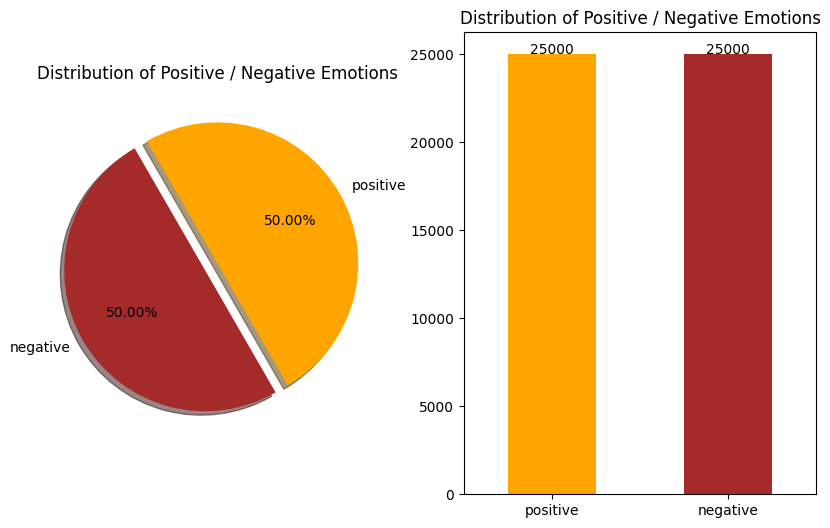

In [6]:
# print the count of the values of label feature

print(reviews_data['sentiment'].value_counts())

# plot the sentiment feature

a , ax = plt.subplots(1,2,figsize = (10,6))
colors = ["orange", "brown"]

reviews_data['sentiment'].value_counts().plot.pie(explode = [0,0.1], autopct = '%1.2f%%',
                                                  ax = ax[0], shadow = True, 
                                                  startangle=300, 
                                                  colors = colors )

ax[0].set_title('Distribution of Positive / Negative Emotions')
ax[0].set_ylabel('')

reviews_data['sentiment'].value_counts().plot(kind='bar', ax=ax[1], color=colors)

ax[1].set_title('Distribution of Positive / Negative Emotions')

# Rotate the x-axis tick labels to be horizontal

ax[1].tick_params(axis='x', rotation=0)

# Add labels inside the bars

counts = reviews_data['sentiment'].value_counts()
for i, count in enumerate(counts):
    ax[1].text(i, count, str(count), ha='center', va='baseline')

plt.show()

# Here we got balance dataset with 25K for each labels

In [7]:
# Check if there are duplicated values

duplicates = reviews_data[reviews_data.duplicated()]

print(f'Number of duplicate rows: {len(duplicates)}')

# so, let's remove the duplicated values
reviews_data.drop_duplicates(inplace=True)

# dimensions of the dataset

a = len(reviews_data)
b = len(reviews_data.columns)

print(f"The IMDB Movie Reviews Dataset has {a} instances and {b} Features.")

Number of duplicate rows: 418
The IMDB Movie Reviews Dataset has 49582 instances and 2 Features.


positive    24884
negative    24698
Name: sentiment, dtype: int64


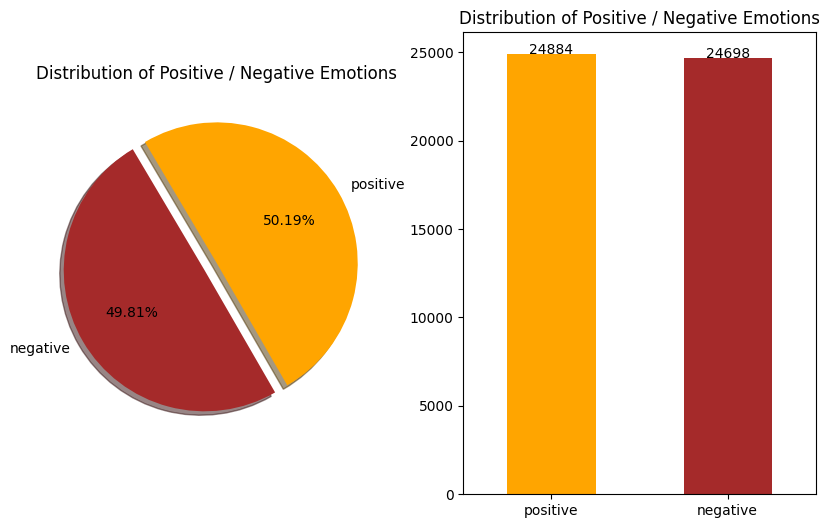

In [8]:
# print the count of the values of label feature

print(reviews_data['sentiment'].value_counts())

# plot the sentiment feature

a , ax = plt.subplots(1,2,figsize = (10,6))
colors = ["orange", "brown"]

reviews_data['sentiment'].value_counts().plot.pie(explode = [0,0.1], autopct = '%1.2f%%',
                                                  ax = ax[0], shadow = True, 
                                                  startangle=300, 
                                                  colors = colors )

ax[0].set_title('Distribution of Positive / Negative Emotions')
ax[0].set_ylabel('')

reviews_data['sentiment'].value_counts().plot(kind='bar', ax=ax[1], color=colors)

ax[1].set_title('Distribution of Positive / Negative Emotions')

# Rotate the x-axis tick labels to be horizontal

ax[1].tick_params(axis='x', rotation=0)

# Add labels inside the bars

counts = reviews_data['sentiment'].value_counts()
for i, count in enumerate(counts):
    ax[1].text(i, count, str(count), ha='center', va='baseline')

plt.show()

## Exploratory data analysis(EDA) and Data Cleaning  

### Sentiment label transformation
As may be seen, we're dealing with a sentiment label in text format. So, in this situation, we need to transform these labels into binary numbers [0,1]
</br>

We will define:
* positive as 1  
* negative as 0


In [9]:
# if the sentiment feauture has the value "positive", then it takes 1
# if the sentiment feauture has the value "negative", then it takes 0

reviews_data['sentiment'].replace({'positive' : 1 , 'negative' : 0} , 
                                  inplace = True)

In [10]:
reviews_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Data preprocessing - remove HTML tags, Punctuations, Stop words and use Word stemming

* HTML tags, punctuations removal
 * Since HTML tags like "br />" and punctuation like "." are not English words and cannot be regarded as features, they should be removed from the original text. 

* Stop words removal
 * Stop words such as 'of' and 'was', are not useful and should also be removed to get rid of negative features.
 
* Word Stemming / Word Lemmatization
 * Stemming is a process of reducing words to their base or root form by removing suffixes
 * Lemmatization is a process of reducing words to their base or dictionary form, called lemmas.
 


In [11]:
# Before preprocessing

print('Before preprocessing:\n', reviews_data['review'][0])

Before preprocessing:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the

### Apply stemming 

After experimenting with various stemming algorithms, including:
- Porter, 
- Snowball, and 
- Lancaster, and evaluating their performance on the sentiment analysis task, we have conclude that while all the stemmers provided some level of word reduction and normalization, the Porter stemming algorithm stood out as the most suitable choice for my specific needs.

In [12]:
# Define the word mapping dictionary
mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have",
    "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
    "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have",
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am",
    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as",
    "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
    "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
    "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}

# Get all the English stopwords
stopwords = set(stopwords.words('english'))

# Initialize a Porter stemmer to stem each word of the review dataset
stemmer = PorterStemmer()

# Initialize corpus list to store all words in the dataset
corpus = []

def preprocessing(data):
    data = data.lower()  # Convert text to lowercase
    data = re.sub(r"http\S+", " ", data)  # Remove hyperlinks from the text
    data = re.sub(r"<.*?>", " ", data)  # Remove HTML tags from the text
    data = re.sub(r"\d+", " ", data)  # Remove numbers from the text
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data = emoji_pattern.sub(r'', data)  # Remove emojis from the text
    punctuations = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'  # Define punctuation symbols
    data = re.sub(punctuations, ' ', data)  # Remove punctuation symbols from the text
    data = re.sub(r'\s{2,}', ' ', data)  # Remove double whitespaces
    words = data.split()  # Split the text into individual words
    processed_words = []  # Initialize list to store processed words

    for word in words:
        if word not in stopwords:  # Check if the word is not a stopword
            word = stemmer.stem(word)  # Stem the word using Porter stemmer
            if word in mapping:
                word = mapping[word]  # Map the word to its expanded form if it exists in the mapping dictionary
            processed_words.append(word)  # Add the processed word to the list
            corpus.extend(processed_words)  # Add the processed word to the corpus list

    cleaned_sentence = " ".join(processed_words)  # Join the processed words to form a cleaned sentence
    return cleaned_sentence


In [13]:
# initialize an empty review list

review = []

# initialize a for loop so as to apply preprocessing steps 

for i in reviews_data['review']:
    review.append(preprocessing(i))
    
# assign the review list into data['review'] column

reviews_data['review'] = review

# After preprocessing

print('After preprocessing:\n', reviews_data['review'][0])

After preprocessing:
 one review mention watch oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch

### Apply lemmatization

The results obtained from lemmatization **did not meet our expectations** in terms of improving the overall performance of our sentiment analysis task. Despite the benefit of obtaining meaningful word forms, the impact on the final sentiment classification was not significant enough to outweigh the computational costs involved.

In [55]:
# # Get all the english stopwords

# stopwords = set(nltk.corpus.stopwords.words('english'))

# # Initialize WordNet lemmatizer

# lemmatizer = WordNetLemmatizer()  

# # Initialize corpus list to store all words in the dataset
    
# corpus = []  

# def get_simplified_pos(tag):
#     if tag.startswith('N'):
#         return 'n'  # Noun
#     elif tag.startswith('V'):
#         return 'v'  # Verb
#     elif tag.startswith('J'):
#         return 'a'  # Adjective
#     elif tag.startswith('R'):
#         return 'r'  # Adverb
#     else:
#         return None

# def preprocessing(data):
#     data = re.sub(r"http\S+", " ", data)  # Remove hyperlinks from the text
#     data = re.sub(r"<.*?>", " ", data)  # Remove HTML tags from the text
#     punctuations = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'  # Define punctuation symbols
#     data = re.sub(punctuations, ' ', data)  # Remove punctuation symbols from the text
#     data = data.lower()  # Convert text to lowercase
#     words = data.split()  # Split the text into individual words
#     processed_words = []  # Initialize list to store processed words
    
#     for word, tag in nltk.pos_tag(words):
#         if word not in stopwords:  # Check if the word is not a stopword
#             simplified_pos = get_simplified_pos(tag)  # Get simplified POS tag
#             if simplified_pos is not None:
#                 word = lemmatizer.lemmatize(word, pos=simplified_pos)  # Lemmatize the word using simplified POS
#             processed_words.append(word)  # Add the processed word to the list
#             corpus.extend(processed_words)  # Add the processed word to the corpus list
    
#     cleaned_sentence = " ".join(processed_words)  # Join the processed words to form a cleaned sentence
#     return cleaned_sentence

In [56]:
# # initialize an empty review list

# review = []

# # initialize a for loop so as to apply preprocessing steps 

# for i in reviews_data['review']:
#     review.append(preprocessing(i))
    
# # assign the review list into data['review'] column

# reviews_data['review'] = review

# # After preprocessing

# print('After preprocessing:\n', reviews_data['review'][0])

# After preprocessing - OUTPUT:
#  one reviewer mention watch 1 oz episode hook right exactly happen 
# first thing strike oz brutality unflinching scene violence set 
# right word go trust show faint hearted timid show pull punch 
# regard drug sex violence hardcore classic use word call oz nickname
# give oswald maximum security state penitentary focus mainly emerald 
# city experimental section prison cell glass front face inwards privacy 
# high agenda em city home many aryan muslim gangstas latinos christian 
# italian irish scuffles death stare dodgy dealing shady agreement never 
# far away would say main appeal show due fact go show dare forget pretty 
# picture paint mainstream audience forget charm forget romance oz mess 
# around first episode ever saw strike nasty surreal say ready watch 
# develop taste oz get accustom high level graphic violence violence 
# injustice crook guard sell nickel inmate kill order get away well 
# mannered middle class inmate turn prison bitch due lack street skill 
# prison experience watch oz may become comfortable uncomfortable view 
# thats get touch darker side

### Visualization of the reviews

#### Bar Plot of Top 20 Most Common Words & Bigrams with Count Labels

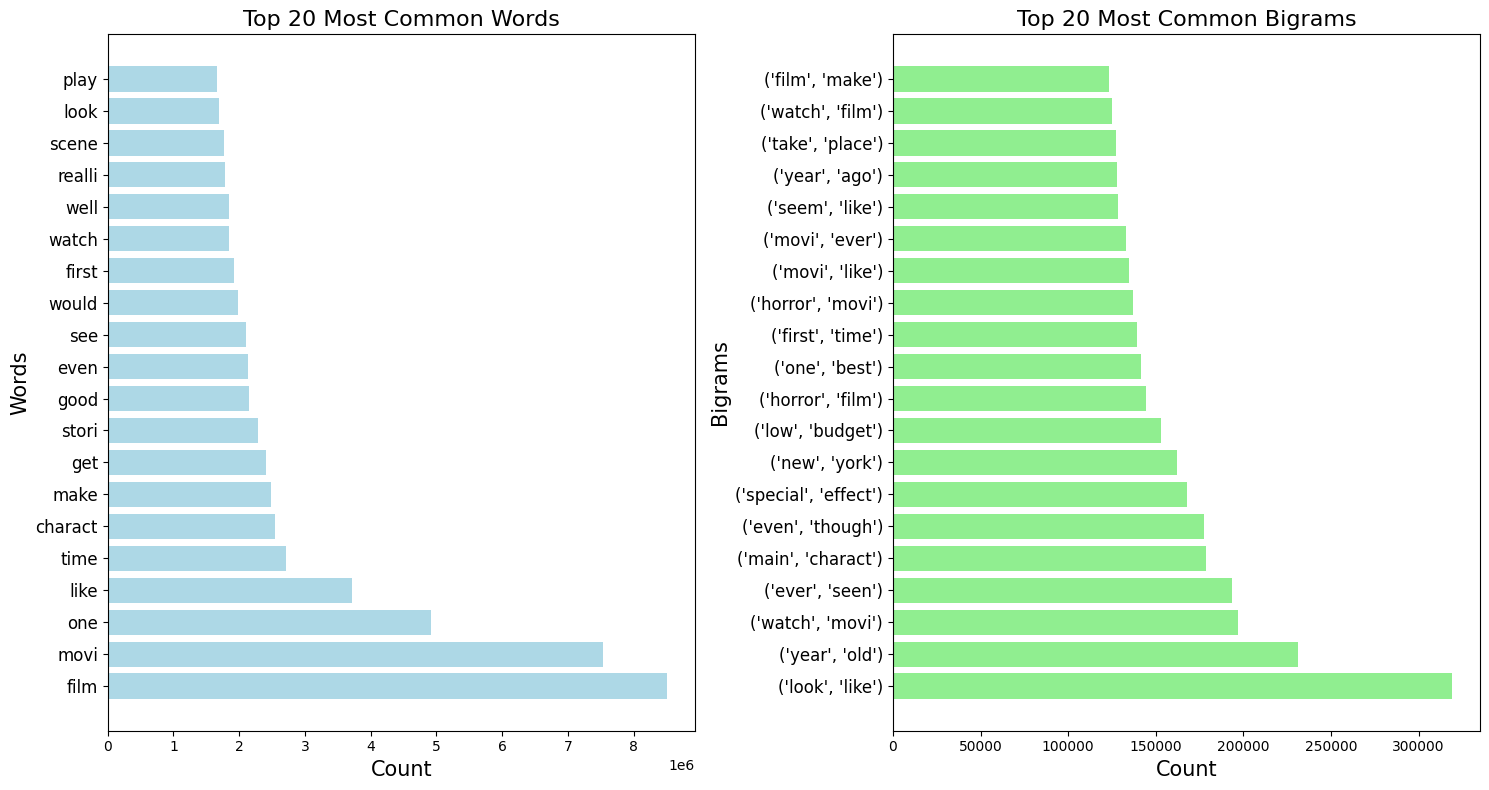

In [14]:
# Create a Counter object to count the occurrences of each word in the corpus
list_of_all_the_words = Counter(corpus)

# Get the top 20 most common words and bigrams and store them in separate variables
top_20_words = dict(list_of_all_the_words.most_common(20))
top_20_bigrams = dict(Counter(ngrams(corpus, 2)).most_common(20))

# Create a new figure with the specified size
plt.figure(figsize=(15, 8))

# Plot the bar chart for the most common words
plt.subplot(1, 2, 1)
plt.barh(range(len(top_20_words)), list(top_20_words.values()), align='center', color='lightblue')
plt.yticks(range(len(top_20_words)), list(top_20_words.keys()), fontsize=12)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Words', fontsize=15)
plt.title('Top 20 Most Common Words', fontsize=16)

# Plot the bar chart for the most common bigrams
plt.subplot(1, 2, 2)
plt.barh(range(len(top_20_bigrams)), list(top_20_bigrams.values()), align='center', color='lightgreen')
plt.yticks(range(len(top_20_bigrams)), list(top_20_bigrams.keys()), fontsize=12)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Bigrams', fontsize=15)
plt.title('Top 20 Most Common Bigrams', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


#### Distribution of the lengths (number of words) of the reviews

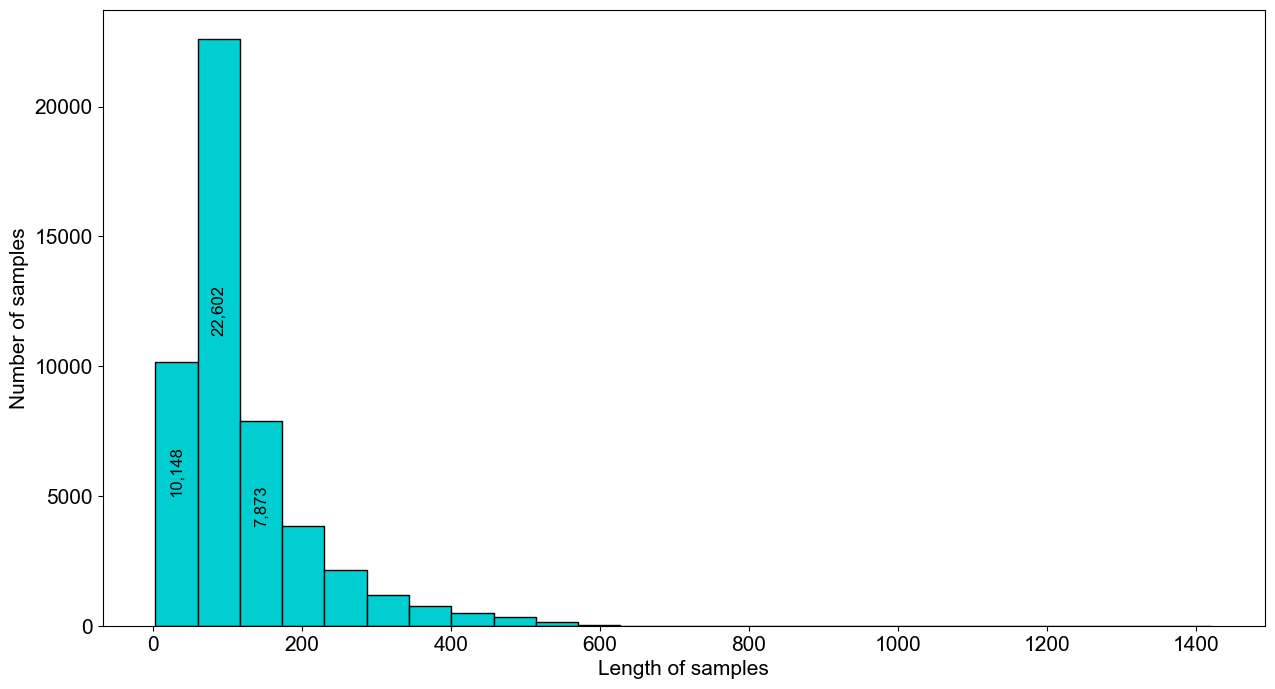

In [15]:
# Create an empty list to store the lengths of samples
lengths = []

# Iterate over each sample in the 'review' column of the 'data' DataFrame
for sample in list(reviews_data['review']):
    # Split the sample into individual words and calculate the length (number of words)
    lengths.append(len(sample.split()))

# Create a new figure with the specified size
plt.figure(figsize=(15, 8))

# Plot a histogram using the 'lengths' list with 25 bins
plt.hist(lengths, 25, color='darkturquoise', edgecolor='black')

# Set the label for the x-axis and y-axis with specified font size
plt.xlabel('Length of samples', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)

# Set the font size for the x-axis and y-axis ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Set the seaborn style to "whitegrid" for aesthetic purposes
sns.set_style("whitegrid", {'axes.grid' : False})

# Add the count of total reviews to each bar
total_reviews = len(reviews_data['review'])
for i, rect in enumerate(plt.gca().patches[:3]):
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height / 2, f'{int(height):,}',
                   ha='center', va='baseline', fontsize=12, color='black', rotation='vertical')
# Display the plot
plt.show()

#### Displaying Word Clouds for Positive and Negative Reviews


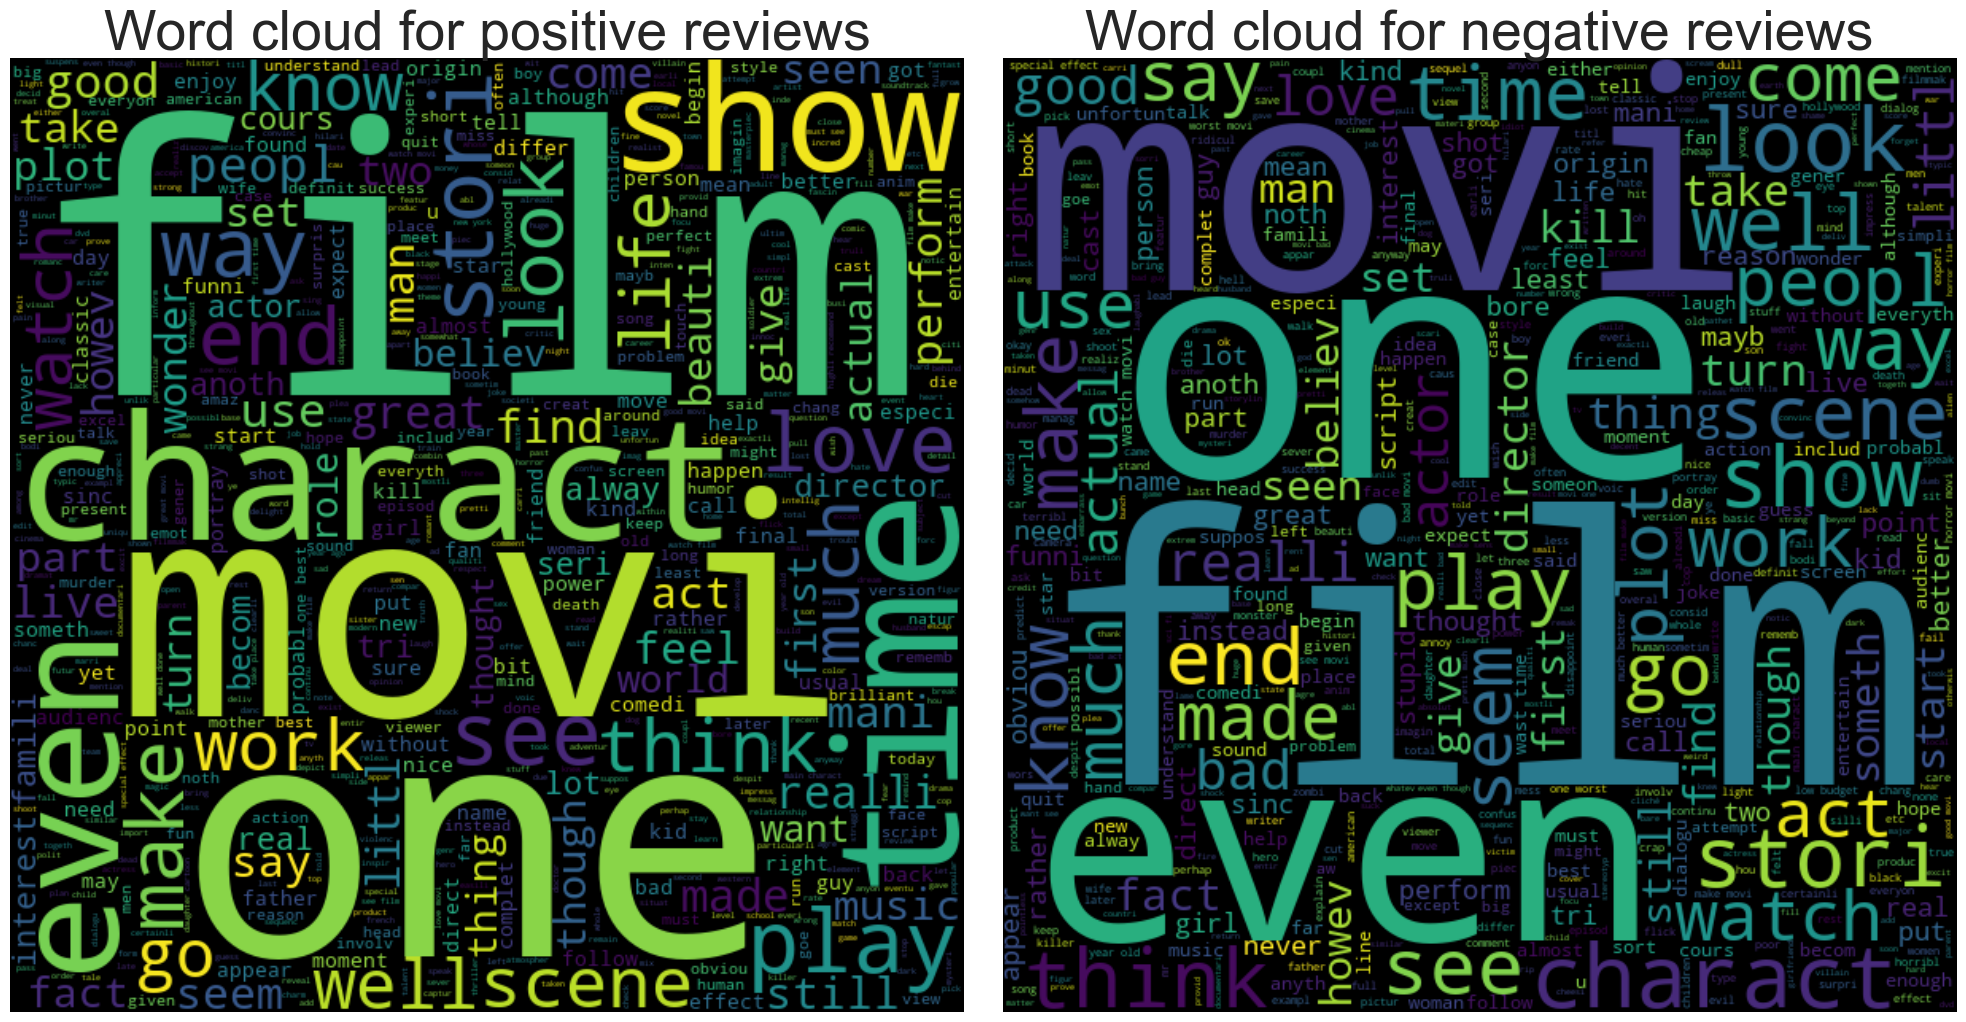

In [16]:
# Extracting positive reviews and converting them into a string
positive_review = reviews_data[reviews_data.sentiment == 1]["review"]
positive_review_string = ' '.join(positive_review)

# Extracting negative reviews and converting them into a string
negative_data = reviews_data[reviews_data.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)

# Creating a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Positive Reviews Word Cloud
wc_positive = WordCloud(max_words=1200, width=600, height=600, background_color="black").generate(positive_review_string)
axes[0].imshow(wc_positive, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word cloud for positive reviews", fontsize=40)

# Negative Reviews Word Cloud
wc_negative = WordCloud(max_words=2000, width=600, height=600, background_color="black").generate(negative_data_string)
axes[1].imshow(wc_negative, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Word cloud for negative reviews", fontsize=40)

plt.tight_layout()
plt.show()


#### Displaying Histograms for Number of Characters and Words in Positive and Negative Reviews

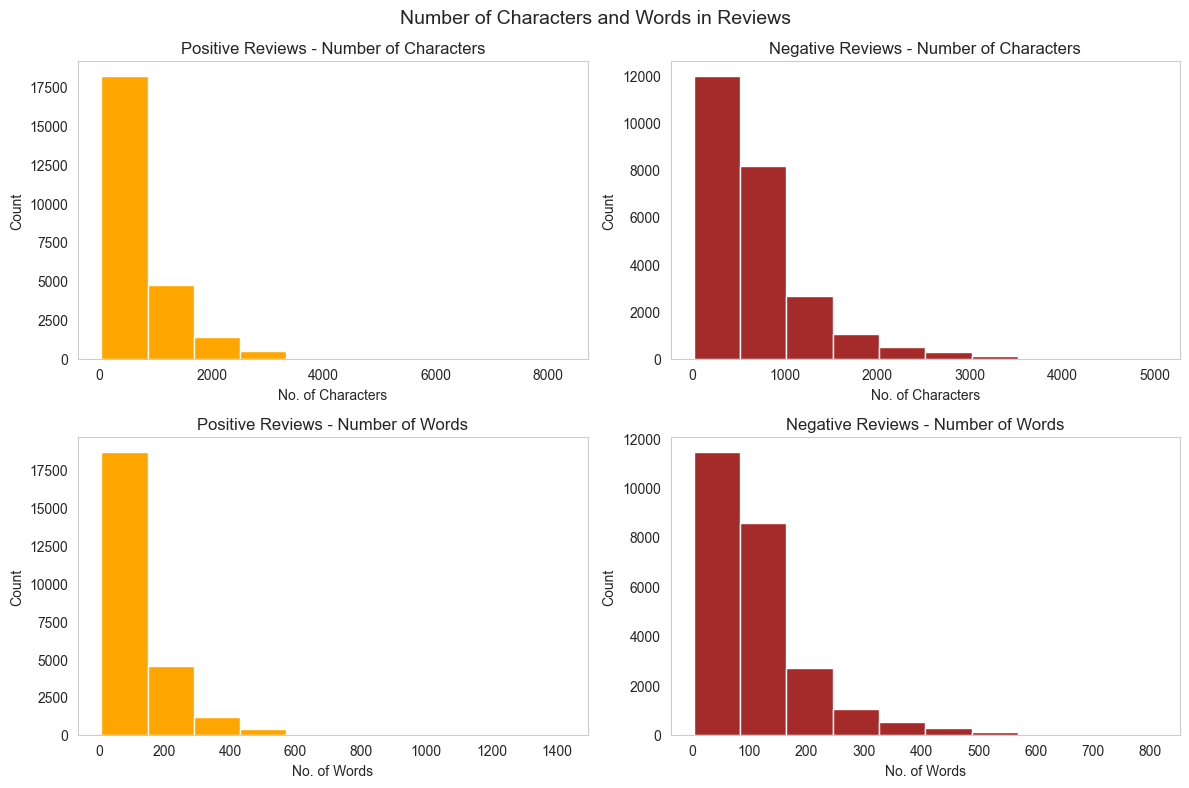

In [17]:
# Creating a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Positive Reviews - Number of Characters
text_len_positive = positive_review.str.len()
axes[0, 0].hist(text_len_positive, color='orange')
axes[0, 0].set_title("Positive Reviews - Number of Characters")
axes[0, 0].set_xlabel("No. of Characters")
axes[0, 0].set_ylabel("Count")

# Negative Reviews - Number of Characters
text_len_negative = negative_data.str.len()
axes[0, 1].hist(text_len_negative, color='brown')
axes[0, 1].set_title("Negative Reviews - Number of Characters")
axes[0, 1].set_xlabel("No. of Characters")
axes[0, 1].set_ylabel("Count")

# Positive Reviews - Number of Words
text_len_positive_words = positive_review.str.split().map(lambda x: len(x))
axes[1, 0].hist(text_len_positive_words, color='orange')
axes[1, 0].set_title("Positive Reviews - Number of Words")
axes[1, 0].set_xlabel("No. of Words")
axes[1, 0].set_ylabel("Count")

# Negative Reviews - Number of Words
text_len_negative_words = negative_data.str.split().map(lambda x: len(x))
axes[1, 1].hist(text_len_negative_words, color='brown')
axes[1, 1].set_title("Negative Reviews - Number of Words")
axes[1, 1].set_xlabel("No. of Words")
axes[1, 1].set_ylabel("Count")

fig.suptitle("Number of Characters and Words in Reviews", fontsize=14)
plt.tight_layout()
plt.show()


In [18]:
# save the clean dataset into new csv file
reviews_data[['review', 'sentiment']].to_csv('imdb_clean_dataset.csv', index=False, header=True)